<a href="https://colab.research.google.com/github/ManojKesani/100-Days-Of-ML-Code/blob/master/cityscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/drive/MyDrive/Projects_ml_ai/cityscape/archive.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: /content/data/cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: /content/data/cityscapes_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r '/content/data/cityscapes_data/cityscapes_data'

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import numpy as np
import os

from keras.utils import Sequence
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D ,Flatten ,Reshape,Concatenate,add
from keras.models import Model ,load_model
import keras
import tensorflow as tf


from IPython.display import clear_output


In [ ]:
epochs = 500
img_shape=(256,256,3)
batch_size=16


#Data_Gen

In [ ]:
class data_gen(Sequence):

  def __init__(self,path_list,batch_size=16,image_shape=(256,256,3)):
    self.path_list = path_list
    self.batch_size = batch_size
    self.image_shape = image_shape
    self.on_epoch_end()

  def __len__(self):
    return len(self.path_list) // self.batch_size

  def __getitem__(self,index):
    paths = self.path_list[index*self.batch_size:(index+1)*self.batch_size]
    x = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], self.image_shape[2]), dtype=np.float32)
    y = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], self.image_shape[2]), dtype=np.float32)

    for idx, path in enumerate(paths):
      inp = np.array(Image.open(path))[:,:256,:]/255.
      out = np.array(Image.open(path))[:,256:512,:]/255.
      x[idx] = inp
      y[idx] = out

    return x,y

  # def on_epoch_end(self):
  #   pass



In [ ]:
train_path_list = []
val_path_list = []

train_path = r'/content/data/cityscapes_data/train'
val_path = r'/content/data/cityscapes_data/val'

for root, dirs, files in os.walk(train_path):
  for file in files:
    train_path_list.append(os.path.join(train_path,file))

for root, dirs, files in os.walk(val_path):
  for file in files:
    val_path_list.append(os.path.join(val_path,file))


train_ds = data_gen(train_path_list)
val_ds = data_gen(val_path_list)

#Bottle_neck model

In [ ]:
def model_gen(img_shape=(256,256,3)):
  input_img = Input(shape=img_shape)
  x = input_img

  for filter in [128,64,32,8]:
    x = Conv2D(filter, (3, 3), activation='relu', padding='same',name = f'C_en_{filter}')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

  for filter in [16,32,64,128]:
    x = Conv2D(filter, (3, 3), activation='relu', padding='same',name = f'C_den_{filter}')(x)
    x = UpSampling2D((2, 2))(x)

  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

  return Model(inputs=input_img, outputs=decoded, name='gen')

model = model_gen()
model.summary()

Model: "gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
C_en_128 (Conv2D)            (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
C_en_64 (Conv2D)             (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
C_en_32 (Conv2D)             (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0       

## Training Bottle_neck model 

In [ ]:
# es = keras.callbacks.EarlyStopping(patience=10)

# class DisplayCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     clear_output(wait=True)
#     inp_img = np.array(Image.open(val_path_list[0]))[:,:256,:]/255.
#     real_mask = np.array(Image.open(val_path_list[0]))[:,256:512,:]/255.
#     pred_mask = model.predict(inp_img[tf.newaxis, ...])
#     show_img = np.concatenate((inp_img,real_mask,pred_mask[0]))
#     plt.imshow(show_img)

callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
]
# loss 'mse','mae'
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mae",
    metrics=["mae"]
)
history = model.fit(
    train_ds, epochs=5, validation_data=val_ds,callbacks = callbacks,
)

Epoch 1/5
185/185 [==============================] - 67s 317ms/step - loss: 0.1528 - mae: 0.1528 - val_loss: 0.1085 - val_mae: 0.1085
Epoch 2/5
185/185 [==============================] - 59s 318ms/step - loss: 0.1038 - mae: 0.1038 - val_loss: 0.0910 - val_mae: 0.0910
Epoch 3/5
185/185 [==============================] - 59s 318ms/step - loss: 0.0900 - mae: 0.0900 - val_loss: 0.0841 - val_mae: 0.0841
Epoch 4/5
185/185 [==============================] - 59s 318ms/step - loss: 0.0847 - mae: 0.0847 - val_loss: 0.0816 - val_mae: 0.0816
Epoch 5/5
185/185 [==============================] - 59s 317ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0789 - val_mae: 0.0789


## loss graph

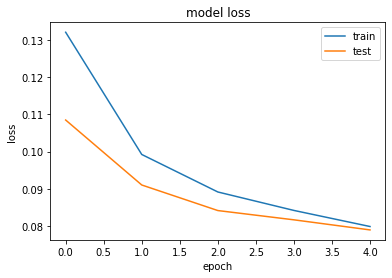

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Plotting preds
 

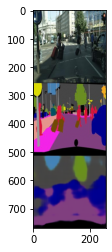

In [ ]:
inp_img = np.array(Image.open(val_path_list[0]))[:,:256,:]/255.
real_mask = np.array(Image.open(val_path_list[0]))[:,256:512,:]/255.
pred_mask = model.predict(inp_img[tf.newaxis, ...])

show_img = np.concatenate((inp_img,real_mask,pred_mask[0]))
plt.imshow(show_img)

#U_net model


In [ ]:
def Unet_model_gen(img_shape=(256,256,3)):
  input_img = Input(shape=img_shape)
  x = input_img

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  l1 = MaxPooling2D((2, 2), padding='same',name = 'l1')(x)

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(l1)
  l2 = MaxPooling2D((2, 2), padding='same',name = 'l2')(x)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(l2)
  l3 = MaxPooling2D((2, 2), padding='same',name = 'l3')(x)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(l3)
  l4 = MaxPooling2D((2, 2), padding='same',name = 'l4')(x)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(l4)
  d4 = UpSampling2D((2, 2),name = 'd4')(x)

  con1 = Concatenate()
  c3 = con1([d4,l3])

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
  d3 = UpSampling2D((2, 2),name = 'd3')(x)

  con2 = Concatenate()
  c2 = con2([d3,l2])

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
  d2 = UpSampling2D((2, 2),name = 'd2')(x)

  con3 = Concatenate()
  c1 = con3([d2,l1])

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(c1)
  d1 = UpSampling2D((2, 2),name = 'd1')(x)


  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d1)

  return Model(inputs=input_img, outputs=decoded, name='gen')

Unet_model = Unet_model_gen()
Unet_model.summary()

Model: "gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 128 3584        input_4[0][0]                    
__________________________________________________________________________________________________
l1 (MaxPooling2D)               (None, 128, 128, 128 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 73792       l1[0][0]                         
________________________________________________________________________________________________

## Training U_net

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
]
# loss 'mse','mae'
Unet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mae",
    metrics=["mae"]
)
history = Unet_model.fit(
    train_ds, epochs=5, validation_data=val_ds,callbacks = callbacks,
)

Epoch 1/5
185/185 [==============================] - 81s 420ms/step - loss: 0.1418 - mae: 0.1418 - val_loss: 0.0912 - val_mae: 0.0912
Epoch 2/5
185/185 [==============================] - 78s 420ms/step - loss: 0.0884 - mae: 0.0884 - val_loss: 0.0785 - val_mae: 0.0785
Epoch 3/5
185/185 [==============================] - 78s 421ms/step - loss: 0.0779 - mae: 0.0779 - val_loss: 0.0745 - val_mae: 0.0745
Epoch 4/5
185/185 [==============================] - 78s 420ms/step - loss: 0.0724 - mae: 0.0724 - val_loss: 0.0723 - val_mae: 0.0723
Epoch 5/5
185/185 [==============================] - 78s 420ms/step - loss: 0.0688 - mae: 0.0688 - val_loss: 0.0700 - val_mae: 0.0700


In [ ]:
keras.utils.plot_model(Unet_model, show_shapes=True)


## loss graph

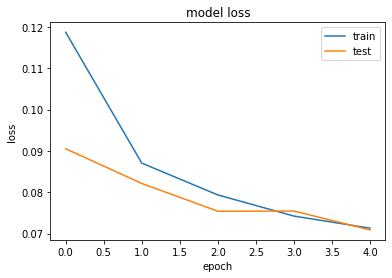

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## plotting preds

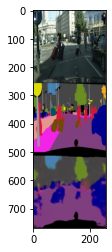

In [ ]:
inp_img = np.array(Image.open(val_path_list[0]))[:,:256,:]/255.
real_mask = np.array(Image.open(val_path_list[0]))[:,256:512,:]/255.
pred_mask = Unet_model.predict(inp_img[tf.newaxis, ...])

show_img = np.concatenate((inp_img,real_mask,pred_mask[0]))
plt.imshow(show_img)

# Linknet model

In [ ]:
def linknet_model_gen(img_shape=(256,256,3)):
  input_img = Input(shape=img_shape)
  x = input_img

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  l1 = MaxPooling2D((2, 2), padding='same',name = 'l1')(x)

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(l1)
  l2 = MaxPooling2D((2, 2), padding='same',name = 'l2')(x)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(l2)
  l3 = MaxPooling2D((2, 2), padding='same',name = 'l3')(x)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(l3)
  l4 = MaxPooling2D((2, 2), padding='same',name = 'l4')(x)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(l4)
  d4 = UpSampling2D((2, 2),name = 'd4')(x)

  c3 = add([d4,l3])

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
  d3 = UpSampling2D((2, 2),name = 'd3')(x)

  c2 = add([d3,l2])

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
  d2 = UpSampling2D((2, 2),name = 'd2')(x)

  c1 = add([d2,l1])

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(c1)
  d1 = UpSampling2D((2, 2),name = 'd1')(x)


  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d1)

  return Model(inputs=input_img, outputs=decoded, name='gen')

linknet_model = linknet_model_gen()
linknet_model.summary()

Model: "gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 128 3584        input_5[0][0]                    
__________________________________________________________________________________________________
l1 (MaxPooling2D)               (None, 128, 128, 128 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 128, 128, 64) 73792       l1[0][0]                         
________________________________________________________________________________________________

In [ ]:
keras.utils.plot_model(linknet_model, show_shapes=True)


##Training Linknet

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
]
# loss 'mse','mae'
linknet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mae",
    metrics=["mae"]
)
history = linknet_model.fit(
    train_ds, epochs=5, validation_data=val_ds,callbacks = callbacks,
)

Epoch 1/5
185/185 [==============================] - 69s 362ms/step - loss: 0.1420 - mae: 0.1420 - val_loss: 0.0905 - val_mae: 0.0905
Epoch 2/5
185/185 [==============================] - 67s 360ms/step - loss: 0.0894 - mae: 0.0894 - val_loss: 0.0821 - val_mae: 0.0821
Epoch 3/5
185/185 [==============================] - 67s 360ms/step - loss: 0.0799 - mae: 0.0799 - val_loss: 0.0754 - val_mae: 0.0754
Epoch 4/5
185/185 [==============================] - 67s 360ms/step - loss: 0.0756 - mae: 0.0756 - val_loss: 0.0755 - val_mae: 0.0755
Epoch 5/5
185/185 [==============================] - 67s 360ms/step - loss: 0.0726 - mae: 0.0726 - val_loss: 0.0709 - val_mae: 0.0709


##loss graph

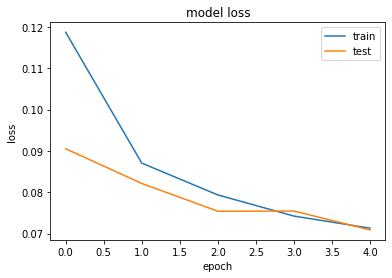

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## plotting preds

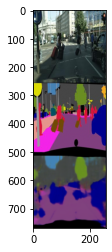

In [ ]:
inp_img = np.array(Image.open(val_path_list[0]))[:,:256,:]/255.
real_mask = np.array(Image.open(val_path_list[0]))[:,256:512,:]/255.
pred_mask = linknet_model.predict(inp_img[tf.newaxis, ...])

show_img = np.concatenate((inp_img,real_mask,pred_mask[0]))
plt.imshow(show_img)